In [1]:
# ------------------------------ Exercise 1 ------------------------------
# Tune the hyperparameters of the training to beat my best validation loss of 2.17

In [238]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [240]:
# build the vocabulary of characters and mappins to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [241]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [242]:
emb_size = 20
hidden_layer_size = 100
mini_batch_size = 1024
regularization = 2

In [243]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((3*emb_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [244]:
sum(p.nelement() for p in parameters)

9367

In [245]:
for p in parameters:
    p.requires_grad = True

In [246]:
def total_loss(setX, setY):
    emb = C[setX]
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, setY) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    return loss.item()

In [247]:
loss_tr = []
loss_dev = []
stepi = []

it_count=200000
report_every_it = 1000
print_every_it = 5000

for i in range(it_count):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%(report_every_it) == 0:
        stepi.append(i)
        loss_tr.append(total_loss(Xtr, Ytr))
        loss_dev.append(total_loss(Xdev, Ydev))
        if i%(print_every_it) == 0:
            print(f"It count: {i}, train loss: {loss_tr[-1]}, dev loss: {loss_dev[-1]}")
        
        
# print(loss.item())

It count: 0, train loss: 22.164934158325195, dev loss: 22.110742568969727
It count: 5000, train loss: 3.5490193367004395, dev loss: 3.562366008758545
It count: 10000, train loss: 2.8175747394561768, dev loss: 2.8264577388763428
It count: 15000, train loss: 2.515599250793457, dev loss: 2.5256471633911133
It count: 20000, train loss: 2.3677351474761963, dev loss: 2.3796639442443848
It count: 25000, train loss: 2.2924695014953613, dev loss: 2.3065078258514404
It count: 30000, train loss: 2.2537903785705566, dev loss: 2.2689571380615234
It count: 35000, train loss: 2.2321958541870117, dev loss: 2.2479729652404785
It count: 40000, train loss: 2.2178659439086914, dev loss: 2.2361550331115723
It count: 45000, train loss: 2.208737373352051, dev loss: 2.2280123233795166
It count: 50000, train loss: 2.200308084487915, dev loss: 2.2216310501098633
It count: 55000, train loss: 2.194851875305176, dev loss: 2.216409921646118
It count: 60000, train loss: 2.189108371734619, dev loss: 2.212928533554077

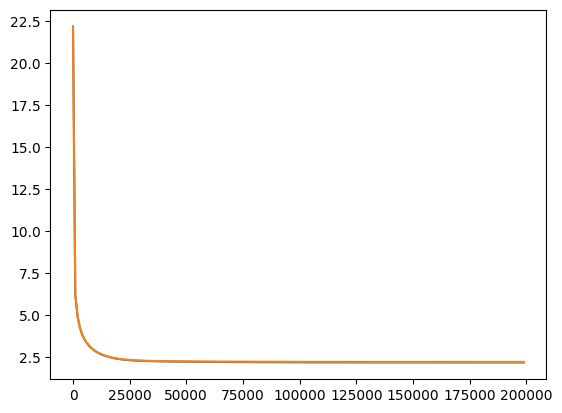

In [248]:
plt.plot(stepi, loss_tr)
plt.plot(stepi, loss_dev)

In [65]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.0875, grad_fn=<NllLossBackward0>)

In [66]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.1185, grad_fn=<NllLossBackward0>)

In [249]:
# Training took 04:18 minutes

In [250]:
# sample from the model

g = torch.Generator().manual_seed(2147483647)
samples = []

for _ in range(100):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        logits = None
        
        h = torch.tanh(emb.view(1, -1) @ a_W1 + a_b1)
        logits = h @ a_W2 + a_b2
            
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        if ix==0:
            break
        out.append(ix)

    samples.append(''.join(itos[i] for i in out))

In [251]:
new_words = [sample for sample in samples if sample not in words]

print(f"Sample len: {len(samples)}")
print(f"New Words len: {len(new_words)}")

print("New words:", new_words)

Sample len: 100
New Words len: 83
New words: ['deabe', 'ahalie', 'aileik', 'aha', 'eilie', 'aia', 'eeleahk', 'aha', 'icheeleiha', 'iah', 'iei', 'kha', 'keiged', 'aea', 'eadee', 'aakaigeagif', 'bai', 'haliel', 'alaheah', 'dhad', 'ahaila', 'kaedeil', 'fie', 'aheaika', 'bhaab', 'aalh', 'khaliellee', 'ablieahhakeechee', 'aia', 'aed', 'ehleileahaleegedlieiahea', 'ebhaleia', 'aahali', 'haae', 'ael', 'keilia', 'fiailcalha', 'fabe', 'eela', 'eehaliah', 'aiah', 'eahi', 'akha', 'geich', 'aihleah', 'eabl', 'aea', 'aaddelia', 'addelkaha', 'cahlacdealiahali', 'hagh', 'had', 'ahahili', 'dha', 'kahaye', 'eck', 'ahal', 'fic', 'aed', 'deelie', 'iei', 'had', 'dahae', 'alei', 'fali', 'eig', 'alkilleaheilea', 'aad', 'eie', 'iab', 'aalief', 'eiae', 'aea', 'geadeaha', 'aia', 'aeh', 'chaeik', 'aha', 'abhaiciawa', 'jaidelie', 'aediegha', 'lha', 'deah']


In [36]:
# ------------------------------ Exercise 2 ------------------------------
# I was not careful with the intialization of the network in this video. 
# (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
# (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

# (1) The starting loss is 7, much lower than with non-uniform initial parameters, however the loss after 200k iterations is 2.4677 (much worse)
# (2) I assume it can be done by initializing C, W and b tensors with zeros and ones

In [55]:
# Initialization

g = torch.Generator().manual_seed(2147483647)
C = torch.ones((27, emb_size))
W1 = torch.ones((3*emb_size, hidden_layer_size))
b1 = torch.zeros(hidden_layer_size)
W2 = torch.ones((hidden_layer_size,27))
b2 = torch.zeros(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [56]:
#Training

loss_tr = []
loss_dev = []
stepi = []

it_count=200000
report_every_it = 1000
print_every_it = 5000

for i in range(it_count):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%(report_every_it) == 0:
        stepi.append(i)
        loss_tr.append(total_loss(Xtr, Ytr))
        loss_dev.append(total_loss(Xdev, Ydev))
        if i%(print_every_it) == 0:
            print(f"It count: {i}, train loss: {loss_tr[-1]}, dev loss: {loss_dev[-1]}")
        
        
# print(loss.item())

It count: 0, train loss: 6.980022430419922, dev loss: 6.979219436645508
It count: 5000, train loss: 4.307507038116455, dev loss: 4.306113243103027
It count: 10000, train loss: 3.460493803024292, dev loss: 3.4585511684417725
It count: 15000, train loss: 3.1187005043029785, dev loss: 3.116990089416504
It count: 20000, train loss: 2.9700562953948975, dev loss: 2.968836545944214
It count: 25000, train loss: 2.915227174758911, dev loss: 2.9129257202148438
It count: 30000, train loss: 2.8632805347442627, dev loss: 2.862459659576416
It count: 35000, train loss: 2.846811532974243, dev loss: 2.8458452224731445
It count: 40000, train loss: 2.8395028114318848, dev loss: 2.837057590484619
It count: 45000, train loss: 2.833026647567749, dev loss: 2.8312292098999023
It count: 50000, train loss: 2.7294132709503174, dev loss: 2.72556734085083
It count: 55000, train loss: 2.596628427505493, dev loss: 2.5883986949920654
It count: 60000, train loss: 2.553548574447632, dev loss: 2.546391010284424
It count

In [57]:
# Loss Train

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.4764, grad_fn=<NllLossBackward0>)

In [58]:
# Loss Dev
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.4677, grad_fn=<NllLossBackward0>)

In [75]:
# ------------------------------ Exercise 3 ------------------------------
# Read the Bengio et al 2003 paper, implement and try any idea from the paper. Did it work?
# Bengio et al 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

# Let's try this one:
# 1. Decomposing the network in sub-networks, for example using a clustering of the words.
# Training many smaller networks should be easier and faster.

# Attempt:
# Split the vocabulary into 2, in the middle --> chars1, chars2
# Train two separate networks, depending on which vocabulary was the last letter in
# Calculate loss
# Sample from the network combination

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [12]:
# build the vocabulary of characters and mappins to/from integers
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()}

chars_split_i = int(len(chars)/2)
a_chars = chars[:chars_split_i]
b_chars = chars[chars_split_i:]

a_chars_size = len(a_chars)
b_chars_size = len(b_chars)

In [13]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words, a_chars, b_chars):
    a_X, a_Y, b_X, b_Y = [], [], [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            if ch in a_chars:
                a_X.append(context)
                a_Y.append(ix)
            else:
                b_X.append(context)
                b_Y.append(ix)
            context = context[1:] + [ix] # crop and append

    a_X = torch.tensor(a_X)
    a_Y = torch.tensor(a_Y)
    b_X = torch.tensor(b_X)
    b_Y = torch.tensor(b_Y)
    return a_X, a_Y, b_X, b_Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

a_Xtr, a_Ytr, b_Xtr, b_Ytr = build_dataset(words[:n1], a_chars, b_chars)
a_Xdev, a_Ydev, b_Xdev, b_Ydev = build_dataset(words[n1:n2], a_chars, b_chars)
a_Xtest, a_Ytest, b_Xtest, b_Ytest = build_dataset(words[n2:], a_chars, b_chars)

In [23]:
emb_size = 20
hidden_layer_size = 50
mini_batch_size = 1024
regularization = 2

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)

a_W1 = torch.randn((3*emb_size, hidden_layer_size), generator=g)
a_b1 = torch.randn(hidden_layer_size, generator=g)
a_W2 = torch.randn((hidden_layer_size,27), generator=g)
a_b2 = torch.randn(27, generator=g)

b_W1 = torch.randn((3*emb_size, hidden_layer_size), generator=g)
b_b1 = torch.randn(hidden_layer_size, generator=g)
b_W2 = torch.randn((hidden_layer_size,27), generator=g)
b_b2 = torch.randn(27, generator=g)

a_parameters = [C, a_W1, a_b1, a_W2, a_b2]
b_parameters = [C, b_W1, b_b1, b_W2, b_b2]
parameters = [C, a_W1, a_b1, a_W2, a_b2, b_W1, b_b1, b_W2, b_b2]

In [24]:
sum(p.nelement() for p in parameters)

9394

In [25]:
for p in parameters:
    p.requires_grad = True

In [26]:
def total_loss(setX, setY, W1, b1, W2, b2):
    emb = C[setX]
    h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, setY) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
    return loss.item()

In [27]:
#Training

for _ in range(2):

    for Xtr,Ytr,Xdev,Ydev,W1,b1,W2,b2, parameters in [(a_Xtr,a_Ytr,a_Xdev,a_Ydev,a_W1,a_b1,a_W2,a_b2, a_parameters),
                                                     (b_Xtr,b_Ytr,b_Xdev,b_Ydev,b_W1,b_b1,b_W2,b_b2, b_parameters)]:

        loss_tr = []
        loss_dev = []
        stepi = []

        it_count=40000
        report_every_it = 1000
        print_every_it = 5000

        for i in range(it_count):

            # minibatch construct
            ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))

            # forward pass
            emb = C[Xtr[ix]] # (32, 3, 2)
            h = torch.tanh(emb.view(-1, 3*emb_size) @ W1 + b1) # (32, 100)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Ytr[ix]) + regularization * (W1**2).mean() + regularization * (W2**2).mean()
            # print(loss.item())

            # backward pass
            for p in parameters:
                p.grad = None
            loss.backward()

            # update
            # lr = lrs[i]
            lr = 0.1 if i < it_count/2 else 0.01 
            for p in parameters:
                p.data += -lr * p.grad

            # track stats
            if i%(report_every_it) == 0:
                stepi.append(i)
                loss_tr.append(total_loss(Xtr, Ytr, W1, b1, W2, b2))
                loss_dev.append(total_loss(Xdev, Ydev, W1, b1, W2, b2))
                if i%(print_every_it) == 0:
                    print(f"It count: {i}, train loss: {loss_tr[-1]}, dev loss: {loss_dev[-1]}")

It count: 0, train loss: 17.398569107055664, dev loss: 17.453584671020508
It count: 5000, train loss: 2.2550759315490723, dev loss: 2.2553458213806152
It count: 10000, train loss: 1.765372395515442, dev loss: 1.7680097818374634
It count: 15000, train loss: 1.647465467453003, dev loss: 1.649801254272461
It count: 20000, train loss: 1.612952709197998, dev loss: 1.6157277822494507
It count: 25000, train loss: 1.609444260597229, dev loss: 1.6120115518569946
It count: 30000, train loss: 1.607559084892273, dev loss: 1.610450029373169
It count: 35000, train loss: 1.605723261833191, dev loss: 1.608553409576416
It count: 0, train loss: 17.847610473632812, dev loss: 17.944202423095703
It count: 5000, train loss: 2.405029058456421, dev loss: 2.430474281311035
It count: 10000, train loss: 1.9169265031814575, dev loss: 1.94203519821167
It count: 15000, train loss: 1.7964328527450562, dev loss: 1.820769190788269
It count: 20000, train loss: 1.759708285331726, dev loss: 1.7838166952133179
It count: 2

In [28]:
# sample from the model

g = torch.Generator().manual_seed(2147483647)
samples = []

for _ in range(100):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        logits = None
        
        if itos[context[2]] in a_chars:
            h = torch.tanh(emb.view(1, -1) @ a_W1 + a_b1)
            logits = h @ a_W2 + a_b2
        else:
            h = torch.tanh(emb.view(1, -1) @ b_W1 + b_b1)
            logits = h @ b_W2 + b_b2
            
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        
        if ix==0:
            break
        out.append(ix)

    samples.append(''.join(itos[i] for i in out))

In [29]:
new_words = [sample for sample in samples if sample not in words]

print(f"Sample len: {len(samples)}")
print(f"New Words len: {len(new_words)}")

print("New words:", new_words)

Sample len: 100
New Words len: 70
New words: ['delie', 'adilah', 'ell', 'ich', 'caidella', 'kakaida', 'jacille', 'jaleigi', 'aai', 'iclaellah', 'jacia', 'daeka', 'kadel', 'akaigeli', 'fell', 'ihilie', 'balah', 'all', 'baleil', 'geal', 'feille', 'deli', 'fie', 'legaika', 'bhaab', 'aale', 'khallee', 'abellia', 'aah', 'keecle', 'jaed', 'lice', 'ellaileah', 'deagadihailee', 'cheille', 'lah', 'deah', 'aajhaad', 'gel', 'keilla', 'ficalcalli', 'kaddailiah', 'behlagha', 'kaelica', 'badelka', 'heacdaiaa', 'jagh', 'calle', 'ahlliklalia', 'kahayvonnonyxnossonnynorttonnytrrynntonnyszynnonyonnoztontustoroornorrynnsmontynontorynnovonnyronnynnnsurmynnnontonnysonsonnontryxsonntonnoynnottusswornozumnsonnystonnynnorustonnontonostytzrumourttynnormontrosstonvynnnonsynnnszorrynnsonnossonnonnyponnynsonortonnstyntonnorynnnwoustorynnonortonnonystoptrosssynnourmynontromononustontrystonnyxtonnonournntonnstonnysstonontryntonntzynnontonustonnzsonnystonyssonnyssontromyrosspsprnyntonnyvonnovonnyxsontryssonnontorynn

In [227]:
# Interesting... it somewhat feels like it worked, but I don't understand how I get so low losses

# Seems like training a_char, then b_char then a_char again helps lower the loss faster
# The training takes 2:45 minutes